# Overview
1) The "What"
2) Very small intermezzo on hydrosimulations
3) The How
    - Loose structure of the code
5) Tutoril

# The "What"
We want to study gravitational lenses obtained from particles of hydrosimulated galaxies- specifically, we want 

1) find lenses
2) compute the $\alpha$ map
3) study their density
4) model the lens from the simulated images
   
While our project will differs in many aspects, these core points should more or less be in common (except some possible different parametric requirement, e.g. the type of lenses, sources etc).


# Very small intermezzo on hydrosimulations
You probably know as well as me, if not better, what an hydrodynamical simulation is. However, just to be sure we all on the same page, I will recap the very basic but necessary informations.
Hydrosims are composed of particles, divided in 4 classes:

1) **dark matter**
2) **gas**
3) **stars**
4) **black holes**

They mainly interact gravitationally, but being hydro (and not only n-body) simulations, they also have peculiar and individual properties: star-formation, feedbacks, accretion etc. For what concerns lensing, however, we luckily can ignore all this and just treat them as massive particles for our lenses. 

Furthermore, the simulations evolve in time (thus in redshifts z), and its properties are then stored at given **snapshots (snap)** in time. Thus **z $\leftrightarrow$ snap**.

In each of these, the galaxy catalogues have been compiled (luckily!). This are list of formed galaxies, with some interesting properties pre-computed (such as Mass and its redshift, properties we can select for). Moreover, these catalogues link the particle to a given galaxy. We can then find the galaxy and then load its particles.

# The "How"
Rough outline of the pipeline:

<figure>
<img src="./tutorial_images/how.png" style="width:100%">
<figcaption align = "center"> 
</figcaption>
</figure>

## Loose structure of the code
(slightly) more detailed structure of the code:
<figure>
<img src="./tutorial_images/pipeline_structure.png" style="width:100%">
<figcaption align = "center"> 

</figcaption>
</figure>

# Tutorial

First we import some generally useful functions and names:

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as const

from python_tools.tools import mkdir,short_SciNot,ensure_unit
from python_tools.get_res import load_whatever

verbose = True

## Sample a galaxy

In [2]:
# Locate the path for the particle data 
part_data_path =  Path("./data_Tuto/")
mkdir(part_data_path)

# define some useful variables to find particles and galaxies
from fnct import tutorial_sim,galdir2sim,sim2galdir

gal_dir = sim2galdir(tutorial_sim,part_path=part_data_path) 
mkdir(gal_dir)
# Where the galaxy are located
print("gal_dir:",gal_dir)

# useful functions to translate from z to snap and viceversa
from fnct import get_z,get_snap,get_z_snap

#eg
snap =20
z = get_z(snap)
print(z)
print(get_snap(z))
print(get_z_snap(z=z))
print("Note the snap is usually a string for convenience")

gal_dir: data_Tuto/RefTuto/Gals
0.87
20
(0.87, '20')
Note the snap is usually a string for convenience



For this tutorial, we won't need to create an EAGLE account and download the whole EAGLE dataset, as I have preselected a galaxy (which turns out to be a lens). The code is structured such that it store intermediate results, and reloads them unless specifically instructed not to. This way, it saves time, while having only a moderate cost in memory.

Note that there are several simulation suites, referred to with the variable "sim" in my code. The usual one I work with is the "RefL0025N0752", which has a comoving box size of 25 cMpc, and 752^3 dark matter particles (it starts with an equal n* of baryonic particles). The galaxy we load will be part of this suite, although for simplicity I created a dummy-simulation called RefTuto for this tutorial.

Finding lenses is the easiest part, if we have a galaxy catalogue (which is the case for EAGLE and COLIBRE luckily). We define a range of redshifts and a minimum mass, and get a list of galaxies that are our lens candidates. 

In [3]:
from get_gal_indexes_tutorial import get_gals


# this function loads the galaxy catalogue
# it first checks if there is a previous one, if there is not, it will try to download it via SQL.
# For this tutorial, I  pre-downloaded the necessary catalogue, as you won't have access to the database without an EAGLE account
# (which is not hard to obtain)
gal_cat = get_gals(sim=tutorial_sim, # name of the simulation to use 
         min_z="0.02",max_z="2", # range of redshifts
         gal_dir = gal_dir, # where to store the results
         plot=False)




Found previous pickled catalogue:
data_Tuto/RefTuto/Gals/CatGal_minM1e12_minZ2e-2_maxZ2e.pkl


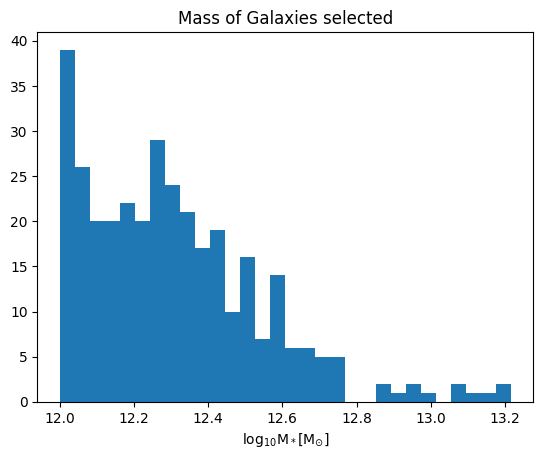

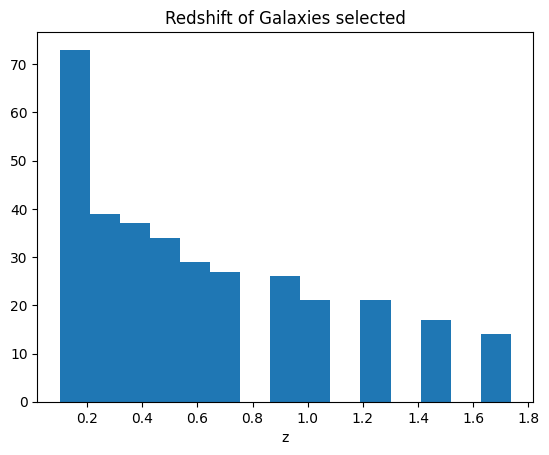

In [4]:
# We can then plot the informative statistic data
logMass = np.log10(gal_cat["M"])
str_logMass = r'log$_{10}$M${_*}$[M$_{\odot}$]'
zGal   = gal_cat["z"]
plt.hist(logMass,bins=30)
plt.title("Mass of Galaxies selected")
plt.xlabel(str_logMass)
plt.show()
plt.close()
plt.hist(zGal,bins=15)
plt.title("Redshift of Galaxies selected")
plt.xlabel(r'z')
plt.show()
plt.close()


In [5]:
print(gal_cat.keys())
print("Number of galaxies in the cat:",len(gal_cat["Gn"]))

dict_keys(['Gn', 'SGn', 'z', 'M', 'CMx', 'CMy', 'CMz', 'query', 'sim'])
Number of galaxies in the cat: 338


As seen, the gal_cat contains the "coordinates" of the interesting galaxies: Group number (Gn) and Sub-Group Number (SGn), which are the indexes of a galaxy within a given snapshot, Redshift (which can be converted into snapshot index), as well as some further informations such as mass and coordinates of the center.

From this list, we can sample a candidate lens, and load its particles from the simulation dataset. We only care about their coordinates and masses, not their type.

In this tutorial, I will directly load a specific, preselected galaxy (to save time and limit memory usage). But in principle it selects a random one with "get_rnd_PG".

In [6]:
#from particle_galaxy import get_rnd_PG
from particle_galaxy import PartGal
Gn = 5
SGn = 0

part_gal = PartGal(Gn=Gn,
                    SGn=SGn,
                    snap=str(snap),
                    sim=tutorial_sim,
                    part_dir=part_data_path,
                    gal_dir=gal_dir)

File data_Tuto/RefTuto/Gals/snap_20/Gn5SGn0.pkl is present
Loaded data_Tuto/RefTuto/Gals/snap_20/Gn5SGn0.pkl:
Gal 5.0, at z=0.865/snap=20, with 
N=2.8E+06 part.
of 
tot Mass=2.4E+12 [M_sun]
 divided in N 
                Stars:2.3E+05
                Gas:8.2E+05
                DM:1.8E+06
                BH:2.4E+01
and Mass in 
                    Stars:3.7E+10 [M_sun]
                    Gas:2.0E+11 [M_sun]
                    DM:2.2E+12 [M_sun]
                    BH:1.0E+07 [M_sun]



### Disclaimer (valid here for the tutorial based on EAGLE data):
Here I tampered the data structure, such that it works while not needing the whole snapshots data. This is usually used to load the cosmological parameters (H0, a) and boxsize (used in EAGLE to correct for boundary terms). 

In short, this will work as if the whole snapshot was available, while actually only the header of the 1st file of the snapshot is given.

## From a galaxy to a Lens
The next steps, which are the core of the pipeline, are "under the hood" of the main class LensPart. All are run with the wrapper function "run()", but we can run them individually to understand the steps

Let us first create the lens class:

### Lens setup

In [7]:
from generate_particle_lens import LensPart
# define the model for the lens particles 
# AS = arshinh, available is also point mass (PM)
from particle_lenses import default_kwlens_part_AS  as kwlens_part_AS

z_source_max = 4

# properties for the image construction 
# - more important later on for the simulation of realistic observations
from generate_particle_lens import kwargs_band_sim
pixel_num = 200 #number of pixels: Important! -> from this we define the resolution of the alpha map

# minimum accepted theta_E
from generate_particle_lens import min_thetaE # 0.3 #arcsec

# type of modelled source: 
# (can be modified - maybe could be implemented differently)
source_model_list         = ['SERSIC_ELLIPSE']

# where to store the lenses
sim_lens_path = Path("./sim_lens_Tuto/") 
mkdir(sim_lens_path)

lens_part = LensPart(Galaxy=part_gal,
                  kwlens_part=kwlens_part_AS,
                  z_source_max=z_source_max, 
                  kwargs_band_sim=kwargs_band_sim,
                  pixel_num=pixel_num,
                  reload=True, # we will not re-compute everything here
                  savedir_sim="tuto_sim_lens", # name of the specific variation of lens algo
                  sim_lens_path = sim_lens_path)



In [8]:
# all computations are done with the "run" call - here it loads prev. results
lens_part.run()
# in this case, this is equivalent to the following:
lens_part.upload_prev() # reload previously computed instance

File sim_lens_Tuto/RefTuto/snap20_G5.0/tuto_sim_lens/Gn5SGn0_Npix200_PartAS.pkl is present
Loaded sim_lens_Tuto/RefTuto/snap20_G5.0/tuto_sim_lens/Gn5SGn0_Npix200_PartAS.pkl:
Gn5SGn0_Npix200_PartAS
File data_Tuto/RefTuto/Gals/snap_20/Gn5SGn0.pkl is present
Loaded data_Tuto/RefTuto/Gals/snap_20/Gn5SGn0.pkl:
Gal 5.0, at z=0.865/snap=20, with 
N=2.8E+06 part.
of 
tot Mass=2.4E+12 [M_sun]
 divided in N 
                Stars:2.3E+05
                Gas:8.2E+05
                DM:1.8E+06
                BH:2.4E+01
and Mass in 
                    Stars:3.7E+10 [M_sun]
                    Gas:2.0E+11 [M_sun]
                    DM:2.2E+12 [M_sun]
                    BH:1.0E+07 [M_sun]

Setting up lensing parameters...
We recenter around the densest point (MD) obtained with AMR
Info:  CM vs Densest 
CM: 0.0 arcsec 0.0 arcsec
Dns: -1.81 arcsec -3.35 arcsec
Dist: 3.8 arcsec


False

### Verify it is a lens: projection_main_AMR.py

We project these particles into a 2D mass distribution and verify if their density is supercritical - even better, we can define a minimum $\theta_E$ such that our lensed images have a minimum of separation and can be resolved:

In [9]:
# we will still do the step "by hand"
from particle_galaxy import Gal2kwMXYZ
from project_gal_AMR import projection_main_AMR

# Read particles ONCE
# kwargs of Msun, XYZ in kpc (explicitely) centered around Centre of Mass (CM)
kw_parts   = Gal2kwMXYZ(lens_part.Gal) 
# Compute projection (uses Adaptive Mesh Refinement for density map estimation)
kwres_proj = projection_main_AMR(Gal=lens_part.Gal,
                                       kw_parts=kw_parts,
                                       z_source_max=lens_part.z_source_max,
                                       sample_z_source=lens_part.sample_z_source,
                                       min_thetaE=lens_part.min_thetaE,
                                       arcXkpc=lens_part.arcXkpc,
                                       verbose=verbose,
                                       save_res=False,
                                       reload=True)


Found and loaded projection from : data_Tuto/RefTuto/Gals/snap_20/proj_part_hist_Gn5SGn0/projection.pkl


In [10]:
kwres_proj

{'proj_index': 0,
 'MD_value': <Quantity 4.26938404e+09 solMass / kpc2>,
 'MD_coords': <Quantity [-14.19180221, -26.32150055] kpc>,
 'z_source_min': np.float32(2.344573),
 'z_source': np.float64(2.3509926911637113),
 'thetaE': <Quantity 0.29927734 arcsec>}

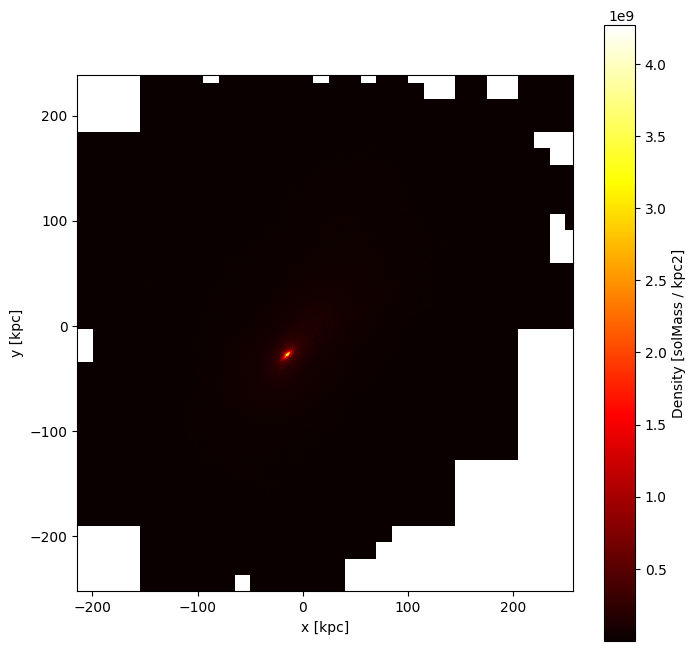

In [11]:
# for more details, check project_gal_AMR.py
from project_gal_AMR import project_kw_parts,dens_map_AMR,plot_amr_cells
#from AMR2D_PLL import plot_amr_cells
proj_index = kwres_proj["proj_index"]

# project particle into a 2D plane
kw_parts_proj = project_kw_parts(kw_parts=kw_parts,
                                 proj_index=proj_index)

# compute density map with AMR
kw_2Ddens = dens_map_AMR(kw_parts_proj=kw_parts_proj,
                         verbose=verbose)
fig,ax = plot_amr_cells(kw_2Ddens)
fig.show()

Locates the minimum z_source for the galaxy to be a lens

Note that for this we have to define a range of source redshift $z_{\text{source}}$, notably the maximum allowed $z_{\text{source max}}$, since the min is given by the lens redshift. 

To be even more picky, we define a minimum Einstein radius $\theta_{min}$, such that the lensed images are separated by a minimum distance/angle, which is then compatible with realistic observational capabilities.

In [12]:
print("Min. theta_E:",lens_part.min_thetaE)

Min. theta_E: 0.3 arcsec


Locating the z_source_min is done  "under the hood" of the get_min_z_source function, which I disasembled here:


pseudo-code (it WONT work, but it explains what happens in the get_min_z_source):
```python
# compute surface density within minimum theta_E 
dens_at_thetamin = getDensAtRad(kw_2Ddens,min_thetaE_kpc)

# this is then the density threshold of this lens 
thresh_dens  = dens_at_thetamin
# to be considered a lens, this density has to be larger than the critical density 
```
remember that 

$\Sigma_{crit} = \frac{D_s}{D_{ds} D_d} \frac{c^2}{4\pi G} \sim f(z_d,z_s)$ 

$z_d$ is given by the redsfhit of the galaxy, thus thresh_dens can be converted into a minimum $z_s$ for the lens to be supercritical.

```python
# convert it into a ratio of angular diameter distances Ds / Dds
thresh_DsDds = thresh_dens*4*np.pi*const.G*cosmo.angular_diameter_distance(z_lens)/(const.c**2) 

# this is the minimum Ds/Dds (ie Ds/Dds with maximum z_source)
min_DsDds = angular_diameter_distance(z_source_max)/angular_diameter_distance_z1z2(z_lens,z_source_max) 

# since DsDds is a very smooth function, we just need to find if and where these meet
z_source_range = np.linspace(z_lens+0.1,z_source_max,100) 
DsDds = np.array([angular_diameter_distance(z_s)./angular_diameter_distance_z1z2(z_lens,z_s)  for z_s in z_source_range])

# Note: successful test means that the threshold density = Sigmacrit given z_source =z_source_min
minimise     = np.abs(DsDds-thresh_DsDds) 
z_source_min = z_source_range[np.argmin(minimise)]
```

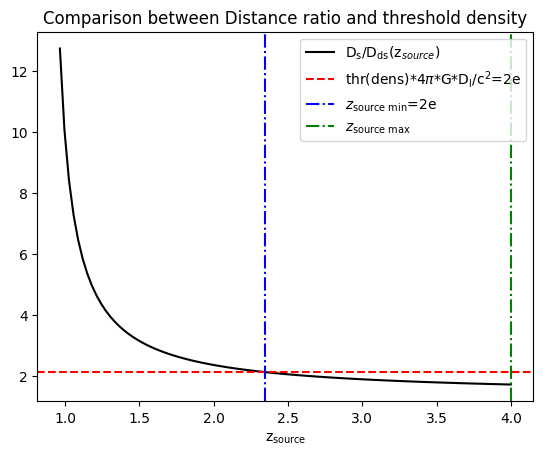

threshold density 2e9 solMass / kpc2
Saved tutorial_images//DsDds.png
This plot is not produced in general


In [13]:
from project_gal_AMR import getDensAtRad
min_thetaE_kpc = lens_part.min_thetaE/lens_part.arcXkpc
z_source_max  =  lens_part.z_source_max

cosmo = lens_part.cosmo
z_lens = lens_part.z_lens

dens_at_thetamin = getDensAtRad(kw_2Ddens,min_thetaE_kpc)
thresh_dens = dens_at_thetamin
thresh_dens  = ensure_unit(thresh_dens,u.Msun/(u.kpc**2))

thresh_DsDds = thresh_dens*4*np.pi*const.G*cosmo.angular_diameter_distance(z_lens)/(const.c**2) 
thresh_DsDds = thresh_DsDds.to("").value # 

min_DsDds = cosmo.angular_diameter_distance(z_source_max)/cosmo.angular_diameter_distance_z1z2(z_lens,z_source_max) # this is the minimum
min_DsDds = min_DsDds.to("").value # dimensionless

z_source_range = np.linspace(z_lens+0.1,z_source_max,100) # it's a very smooth funct->
DsDds = np.array([cosmo.angular_diameter_distance(z_s).to("Mpc").value/cosmo.angular_diameter_distance_z1z2(z_lens,z_s).to("Mpc").value for z_s in z_source_range])

minimise     = np.abs(DsDds-thresh_DsDds) 
z_source_min = z_source_range[np.argmin(minimise)]

fig_dsdds,ax = plt.subplots()
ax.plot(z_source_range,DsDds,ls="-",c="k",label=r"D$_{\text{s}}$/D$_{\text{ds}}$(z$_{source}$)")
ax.set_xlabel(r"z$_{\text{source}}$")
ax.axhline(thresh_DsDds,ls="--",c="r",label=r"thr(dens)*4$\pi$*G*D$_{\text{l}}$/c$^2$="+str( short_SciNot(thresh_DsDds)))
ax.axvline(z_source_min,ls="-.",c="b",label=r"$z_{\text{source min}}$="+str(short_SciNot(z_source_min)))
ax.axvline(z_source_max,ls="-.",c="g",label=r"$z_{\text{source max}}$")
ax.set_title("Comparison between Distance ratio and threshold density")
ax.legend()
name = "tutorial_images//DsDds.png"
fig_dsdds.savefig(name)
plt.show()

plt.close(fig_dsdds)
print("threshold density",short_SciNot(thresh_dens.value),thresh_dens.unit)
print(f"Saved {name}")
print("This plot is not produced in general")

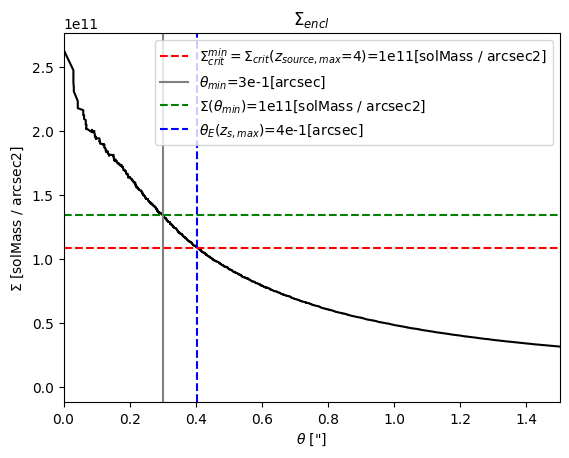

In [14]:
from project_gal_AMR import get_min_z_source
kw_z_min = get_min_z_source(Gal=lens_part.Gal,
                        min_thetaE_kpc=min_thetaE_kpc,
                        kw_2Ddens=kw_2Ddens,
                        z_source_max=z_source_max,
                        savenameSigmaEnc="tutorial_images/Sigma_enc.png",
                        verbose=verbose)

Once obtained $z_{\text{source min}}$, the $z_{\text{source}}$ is sampled (for now, uniformily $U(z_{\text{source min}},z_{\text{source max}})$) . From that the critical surface density is computed $\Sigma_{\text{crit}}$, and thus an estimate of the Einstein radius $\theta_E$.

In [15]:
# in order to re-obtain exactly the same results, we do not re-sample the z_source
z_source = lens_part.z_source

In [16]:
# ThetaE is computed by get_rough_thetaE_PLL, which in turn 
# calls theta_E_from_AMR_densitymap_PLL
from project_gal_AMR import get_rough_thetaE_PLL
thetaE = get_rough_thetaE_PLL(kw_2Ddens,
                              cosmo,
                              lens_part.z_lens,
                              lens_part.z_source,
                              path=lens_part.Gal.proj_dir,
                              fig_Sig=kw_z_min["fig_Sig"])
print("Theta_E:",thetaE)

#"under the hood":

Dd      = cosmo.angular_diameter_distance(z_lens).to("Mpc")
Ds      = cosmo.angular_diameter_distance(z_source).to("Mpc")
Dds     = cosmo.angular_diameter_distance_z1z2(z_lens,z_source).to("Mpc") 

# which runs as follows
from project_gal_AMR import theta_E_from_AMR_densitymap_PLL
kw_Ddds = {"Dd":Dd,"Dds":Dds,"Ds":Ds}
theta_E_from_AMR_densitymap_PLL(kw_2Ddens=kw_2Ddens,
                                path=Path("tutorial_images/"),
                                fig_Sig=kw_z_min["fig_Sig"],
                                **kw_Ddds)
# Which does the same as it follows here
from project_gal_AMR import cells2SigRad
Sigma_crit = (const.c**2 / (4*np.pi*const.G) * (Ds/(Dd*Dds))).to("Msun/kpc^2")
# Physical scale of 1 arcsec at Dd
arcXkpc = u.rad.to("arcsec")*u.arcsec/Dd.to("kpc") # arcsec/kpc (on the lens plane)

r_sorted,Sigma_encl = cells2SigRad(kw_2Ddens)
# theta
theta = r_sorted*arcXkpc

Sigma_crit_arcsec2 = Sigma_crit/(arcXkpc**2)
Sigma_encl_arc2    = Sigma_encl/(arcXkpc**2)

assert Sigma_crit_arcsec2.unit==Sigma_encl_arc2.unit

thetaE = np.interp(Sigma_crit_arcsec2.value, Sigma_encl_arc2.value[::-1], theta[::-1].value)*theta.unit
print("theta_E_arcsec found",short_SciNot(np.round(thetaE,2)))


theta_E_arcsec found 4e-1[arcsec]
Saving data_Tuto/RefTuto/Gals/snap_20/proj_part_hist_Gn5SGn0/Sigma_AMR.png
Theta_E: 0.3584618389755045 arcsec
theta_E_arcsec found 4e-1[arcsec]
Saving tutorial_images/Sigma.png
theta_E_arcsec found 4e-1[arcsec]


<figure>
<img src="./data_Tuto/RefTuto/Gals/snap_20/proj_part_hist_Gn5SGn0/Sigma_AMR.png" style="width:100%">
<figcaption align = "center"> 

The black curve is the enclosed surface density $\Sigma_{encl}$ within an aperture $\theta$

$\Sigma_{crit}^{min}=\Sigma_{crit}(z_{source\, max}=4)$ is the minimum critical density allowed for the galaxy to be considered a lens, i.e. the critical density if the source is at the maximum allowed redshift  $z_{source\, max}$ (by default  $z_{source\, max}=$4)

$\theta_{min}$ is the minum allowed $\theta_E$

$\Sigma(\theta_{min})$ is the surface density at $\theta_{min}$ for this galaxy

$\theta_E(z_{s,max})$ is the Einstein radius of this lens if the source is located at the maximum allowed redshift $z_{source\, max}$.


$\Sigma_{crit}$ is the critical density given the sampled source redshift

$\theta_E$ is the resulting Einstein radius for this lens.
</figcaption>
</figure>

The computation of Einstein angle are approximate, since we are reducing the 2D density distribution into 1D, so it is appropriate only as a rough estimate of the 'size' of the lens.

Once we proved that it is a lens, we can compute the lensing properties of the galaxy, most importantly the $\alpha$ map.
First, some minor setup is then done in the run function. Most importantly, we define the resolution of the image by taking the 2x estimate $\theta_E$ as our aperture, centred around the coordinate of the maximum density (MD), and a number of pixel given as input (def.200).



In [17]:
print("thetaE",lens_part.thetaE)
print("radius",lens_part.radius)
print("pixel_num", lens_part.pixel_num)
print("2*radius/pixel_num", 2*lens_part.radius/lens_part.pixel_num)
print("deltaPix", lens_part.deltaPix)


thetaE 0.3584618389755045 arcsec
radius 0.716923677951009 arcsec
pixel_num 200
2*radius/pixel_num 0.00716923677951009 arcsec
deltaPix 0.00716923677951009 arcsec


### Lensing computations

The code then computes the $\alpha$ map by taking advantage of the highly vectorisable and parallelisable computation: 
- each particle create a very easily computable deflection map
- the total deflection map is simply the sum over all particles
The main issue is the number of particles, but vectorising the inputs and using numba, the computations is fairly fast (~20 min) even with ~10^6 particles. It might even be pushed further with GPUs (not implemented yet).
- moreover, the computations is splitted in "chuncks", ie group of particles, computed iteratively. The size of the chuncks is adapted to the memory budget. Thus the computation should never fail, but at worse take longer

In [18]:
print("N part = ",short_SciNot(lens_part.Gal.N_tot_part))
print("time taken in the cluster for the whole lensing computation: ~20 min")
print("note - computing the lensing potential apparently takes much longer, ~40min")

N part =  3e6
time taken in the cluster for the whole lensing computation: ~20 min
note - computing the lensing potential apparently takes much longer, ~40min


To save time, all computations are already done and stored for this lens. 

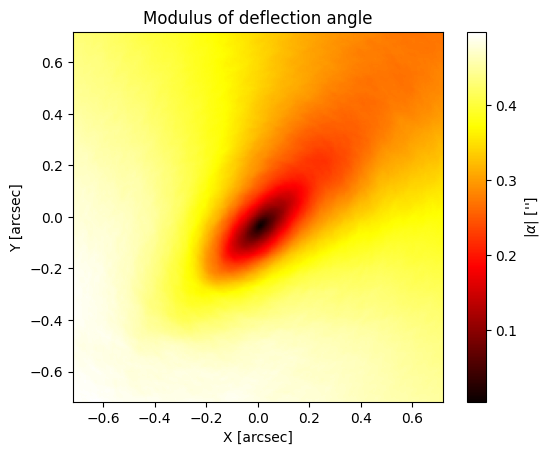

In [19]:

plt.title("Modulus of deflection angle")
kw_extents = lens_part.kw_extents
extent_arcsec = kw_extents["extent_arcsec"]

plt.imshow(np.sqrt(lens_part.alpha_map[0]**2 + lens_part.alpha_map[1]**2),
           extent=extent_arcsec,origin="lower",cmap="hot")
plt.xlabel("X [arcsec]")
plt.ylabel("Y [arcsec]")
plt.colorbar(label=r"|$\alpha$| ['']")

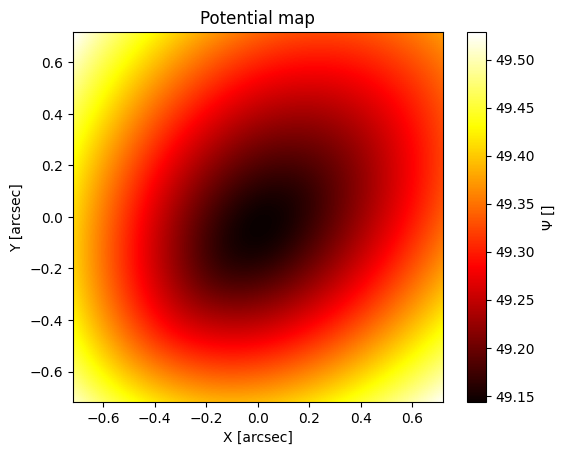

In [20]:

plt.title("Potential map")
kw_extents = lens_part.kw_extents
extent_arcsec = kw_extents["extent_arcsec"]

plt.imshow(lens_part.psi_map,
           extent=extent_arcsec,origin="lower",cmap="hot")
plt.xlabel("X [arcsec]")
plt.ylabel("Y [arcsec]")
plt.colorbar(label=r"$\Psi$ []")

In [21]:
from plot_PL import plot_all
plot_all(lens_part,savename_lensed="lensed_im.png")

Saving sim_lens_Tuto/RefTuto/snap20_G5.0/tuto_sim_lens/lensed_im.png
Saving sim_lens_Tuto/RefTuto/snap20_G5.0/tuto_sim_lens/caustics.png


0


<figure>
<img src="./sim_lens_Tuto/RefTuto/snap20_G5.0/tuto_sim_lens/lensed_im.png">
<figcaption align = "center"> 
    Convergence and Lensed image
</figcaption>
</figure>


<figure>
<img src="./sim_lens_Tuto/RefTuto/snap20_G5.0/tuto_sim_lens/caustics.png">
<figcaption align = "center"> 
    Caustics and critical curves
</figcaption>
</figure>

## Simulating observations

Finally we can do some more realistic observation by following the SimAPI convention of lenstronomy

In [22]:
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST

band_HST = HST(band='WFC3_F160W', psf_type="GAUSSIAN")

SimObs_HST = lens_part.get_SimObs(band_HST,kwargs_source_model=None)

image_hst = lens_part.sim_image(SimObs_HST)


Pixel_num:  17
DeltaPix:  0.08


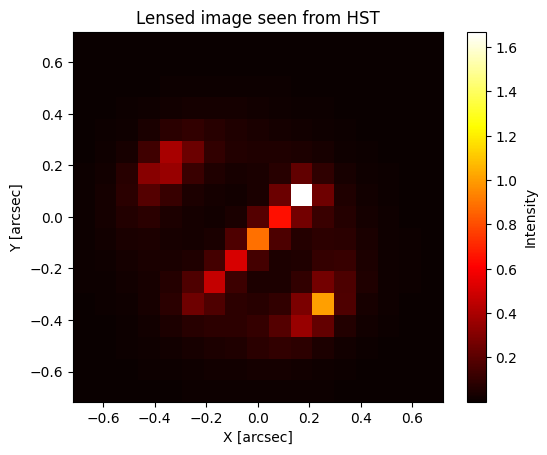

In [23]:

plt.imshow(image_hst,
           extent=extent_arcsec,origin="lower",cmap="hot")
plt.xlabel("X [arcsec]")
plt.ylabel("Y [arcsec]")
plt.title("Lensed image seen from HST")
plt.colorbar(label=r"Intensity")

Pixel_num:  22
DeltaPix:  0.063


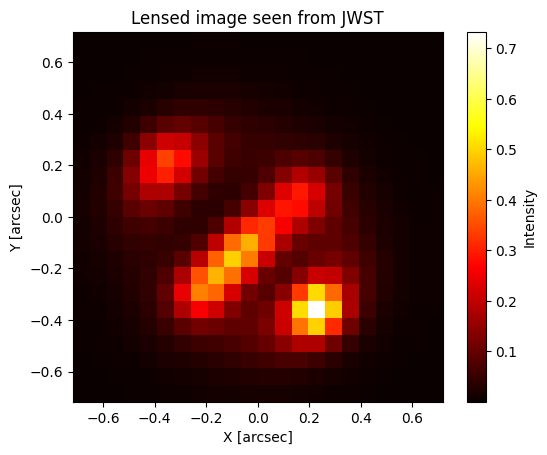

In [24]:
from lenstronomy.SimulationAPI.ObservationConfig.JWST import JWST

band_JWST = JWST(band='F444W', psf_type="GAUSSIAN")

SimObs_JWST = lens_part.get_SimObs(band_JWST,kwargs_source_model=None)

image_jwst = lens_part.sim_image(SimObs_JWST)

plt.imshow(image_jwst,
           extent=extent_arcsec,origin="lower",cmap="hot")
plt.xlabel("X [arcsec]")
plt.ylabel("Y [arcsec]")
plt.title("Lensed image seen from JWST")
plt.colorbar(label=r"Intensity")

## Studying the density
We can then compute the kappa map, or even better fit the isodensity contours with ellipses + multipoles perturbations:

Note: this part is still WIP 

In [26]:

from isodens import plot_isodens,plot_isopot,get_iso_cutoff
scale_cutoff = 20
savedir = Path("tutorial_images/")
cutoff_rad = get_iso_cutoff(lens_part,scale_cutoff)


Cutting plot at 56.355 kpc, 20 times the approx. theta_E


In [29]:

kw_res = plot_isodens(lens_part,savedir,cutoff_rad=cutoff_rad,reload=False)


Cutoff radius larger than pixel grid
cutoff_rad 56.35529625850362
image_rad 5.635529625850362
Computing kappa map from density map...
We recenter around the densest point (MD) obtained with AMR
Info:  CM vs Densest 
CM: 0.0 arcsec 0.0 arcsec
Dns: -1.81 arcsec -3.35 arcsec
Dist: 3.8 arcsec
INFO: Found center at x0 = 100.0, y0 =  99.0 [photutils.isophote.geometry]
Original guesstimate: 100.0 100.0
Saving isofit: sim_lens_Tuto/RefTuto/snap20_G5.0/tuto_sim_lens/kw_res_isodens.dll
Saving tutorial_images/kappa_model.png


/pbs/home/g/gqueirolo/EAGLE/isodens.py:179: RuntimeWarning: divide by zero encountered in log10
  im_i = ax1.imshow(np.log10(map),cmap=plt.cm.inferno,origin="lower",extent=extent)
/pbs/home/g/gqueirolo/EAGLE/isodens.py:186: RuntimeWarning: divide by zero encountered in log10
  im_i = ax2.imshow(np.log10(model),cmap=plt.cm.inferno,origin="lower",extent=extent)


Saving tutorial_images/kappa_prms1.png
Saving tutorial_images/kappa_prms2.png


/pbs/home/g/gqueirolo/EAGLE/isodens.py:319: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(np.log10(sma_kpc),np.log10(isolist.intens),c="k")


Saving tutorial_images/kappa_map.png
Saving tutorial_images/gamma_r.png


$\kappa$ profile:
<figure>
<img src="./tutorial_images/kappa_map.png">
</figure>


Isodensity model:
<figure>
<img src="./tutorial_images/kappa_model.png">
</figure>


Fit parameters of the isodensity ellipses as a function of radius $\theta$
<figure>
<img src="./tutorial_images/kappa_prms1.png">
</figure>
<figure>
<img src="./tutorial_images/kappa_prms2.png">
</figure>

Power law index $\gamma$ as function of $\theta$
<figure>
<img src="./tutorial_images/gamma_r.png">
</figure>


~We can do the same analysis on the potential~
In principle yes, but the scale would have to be either smaller than the cutout of the image $=2*\theta_E$ (too small for the standard fit), or we would have to recompute the potential (time consuming)

In [49]:
cutoff_rad = lens_part.radius/lens_part.arcXkpc
# the following outright fails due to the psi_map being increasing at increasing theta 
# (which is not expected for isophotes
#kw_res = plot_isopot(lens_part,savedir,cutoff_rad=cutoff_rad,reload=False)

In [50]:
from photutils.isophote import Ellipse, EllipseGeometry, build_ellipse_model
map  = 1/lens_part.psi_map
geom = EllipseGeometry(map.shape[0]/2., map.shape[1]/2., 10., 0.5, 0./180.*np.pi)
geom.find_center(map)
print("Original guesstimate:", map.shape[0]/2., map.shape[1]/2.)

ellipse = Ellipse(map, geometry=geom)
isolist = ellipse.fit_image(sma0=10)

model = build_ellipse_model(map.shape, isolist)
cutoff_rad = lens_part.radius/lens_part.arcXkpc
kw_isopot = {"isolist":isolist,"geom":geom,"map":map,"model":model,"cutoff_rad":cutoff_rad.value,"map_type":"psi"}
kw_res = {"isofit":kw_isopot,"cutoff_rad":cutoff_rad.value}
from isodens import plot_isofit
kw_res = plot_isofit(lens_part,map_type="psi",
            savedir=Path("./tutorial_images/"),
            kw_res=kw_res,
            pixel_num=len(map))
plt.close()

INFO: Found center at x0 = 101.0, y0 =  95.0 [photutils.isophote.geometry]
Original guesstimate: 100.0 100.0
Cutting plot at 5.636 kpc, 2 times the approx. theta_E
Saving tutorial_images/psi_model.png
Saving tutorial_images/psi_prms1.png
Saving tutorial_images/psi_prms2.png



$\psi$ model
<figure>
<img src="./tutorial_images/psi_model.png">
</figure>


Fit parameters of the isodensity ellipses as a function of radius $\theta$
<figure>
<img src="./tutorial_images/psi_prms1.png">
</figure>
<figure>
<img src="./tutorial_images/psi_prms2.png">
</figure>


## WIP: Lens modelling

Using lenstronomy, we can then take the simulated images (note: I want to implement more realistic PSFs) and model them.
For that, check the "model_sim_lens.py" file